In [1]:
from armageddon.solver import Planet
from armageddon.locator import great_circle_distance, PostcodeLocator
from armageddon.damage import damage_zones, impact_risk
from armageddon.mapping import plot_circle, damage_map
from armageddon.extensions import findstrengthradius
earth = Planet()

# 1. Armageddon: solver

## `solver` module
* Solve the system of differential equations describing meteoroid entry
* Calculate the kinetic energy lost per unit altitude
* Compute the burst altitude, burst energy and horizontal path length from the entry point

In [2]:
# import basic requirements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### `Planet()` class

The class `Planet()` contains functions to solve the system of ordinary differential equations and analyse the outcomes. It consists of three main functions:
* `solve_atmospheric_entry` for intial calculation for the ODE system
* `calculate_energy` for computing the kinetic energy loss
* `analyse_outcome` for computing the burst parameters

The `__init__` function sets up initial parameters and constants for the target planet, which is Earth in our case.

### Function name: `solve_atmospheric_entry`

Solve the system of differential equations for a given impact scenario

`Input:` 

**radius** : float, the radius of the asteroid in meters

**velocity** : float, the entery speed of the asteroid in meters/second

**density** : float, the density of the asteroid in kg/m^3

**strength** : float, the strength of the asteroid (i.e. the maximum pressure it can take before fragmenting) in N/m^2

**angle** : float, The initial trajectory angle of the asteroid to the horizontal By default, input is in degrees. If 'radians' is set to True, the input should be in radians

**init_altitude** : float, optional Initial altitude in m

**dt** : float, optional The output timestep, in s

**radians** : logical, optional Whether angles should be given in degrees or radians. Default=False Angles returned in the dataframe will have the same units as the input

**backend** : str, optional Which solving method to use. Default='RK4'

`Output:`

**DataFrame**: A pandas dataframe containing the solution to the system, which includes the following columns: 'velocity', 'mass', 'angle', 'altitude', 'distance', 'radius', 'time'

### Method 

One can choose different backend to solve the ODE system as an input for `solve_atmospheric_entry`:
 * 4th-Order Runge Kutta - `'RK4'`
 * Foward-Euler - `'FE'`
 
 The function will take a string argument as an input to decide which solving method to use. If none assigned, it will take 'FE' when $dt < 0.02$ and 'RK4' when $dt>=0.02$ . 

For **Simple Euler Method(Forward Euler)**, the algorithm behind it is simple:( *Note that all given ODEs are time_independent.*)
$$\bar{f}_{i+1} = \bar{f}_i + \delta t F(\bar{f}_i)$$

**RK4** is probably the most popular Runge Kutta method of order p=4 (i.e. its global error scales as $\delta t^4$) with s = 4 stages. The simple explicit expressions is given as follows:
$$\eta^1_i = F(\bar{f}_i)$$
$$\eta^2_i = F(\bar{f}_i+\frac{\delta t}{2}\eta^1_i)$$ 
$$\eta^3_i = F(\bar{f}_i+\frac{\delta t}{2}\eta^2_i)$$ 
$$\eta^4_i = F(\bar{f}_i+\delta t \eta^3_i )$$

$$\bar{f}_{i+1} = \bar{f}_i + \frac{\delta t}{6}(\eta^1_i + 2\eta^2_i + 2\eta^3_i + \eta^4_i)$$

Based on the idea of getting more precise solutions by estimating the slope of the unknown function at several **intermediate points** between the current value $t_i$ and the next value $t_{i+1}$.To sum up, RK4 solver offers a good balance between order of accuracy and cost of computation compared with Forward Euler.

### Example

In [3]:
result1 = earth.solve_atmospheric_entry(radius=35, angle=45,
                                       strength=1e7, density=3000,
                                       velocity=19e3)
result1

,velocity,mass,angle,altitude,distance,radius,time
0,19000.000000,5.387831e+08,45.000000,100000.000000,0.000000,35.000000,0.00
1,19000.346519,5.387831e+08,44.995097,99328.272076,661.441893,35.000000,0.05
2,19000.692985,5.387831e+08,44.990194,98656.587585,1323.015629,35.000000,0.10
3,19001.039389,5.387830e+08,44.985289,97984.950169,1984.732227,35.000000,0.15
4,19001.385736,5.387830e+08,44.980383,97313.356228,2646.580731,35.000000,0.20
...,...,...,...,...,...,...,...
1105,85.070285,8.775432e+07,89.193409,19.445489,97240.990478,257.488437,55.25
1106,85.046678,8.775428e+07,89.197701,15.192961,97241.050195,257.488437,55.30
1107,85.023083,8.775425e+07,89.201969,10.941655,97241.109564,257.488437,55.35
1108,84.999499,8.775421e+07,89.206215,6.691477,97241.168614,257.488437,55.40


One could visualise the evolution of the asteroid in the atmosphere by plotting some graphs of the asteroid parameters against altitude or time.

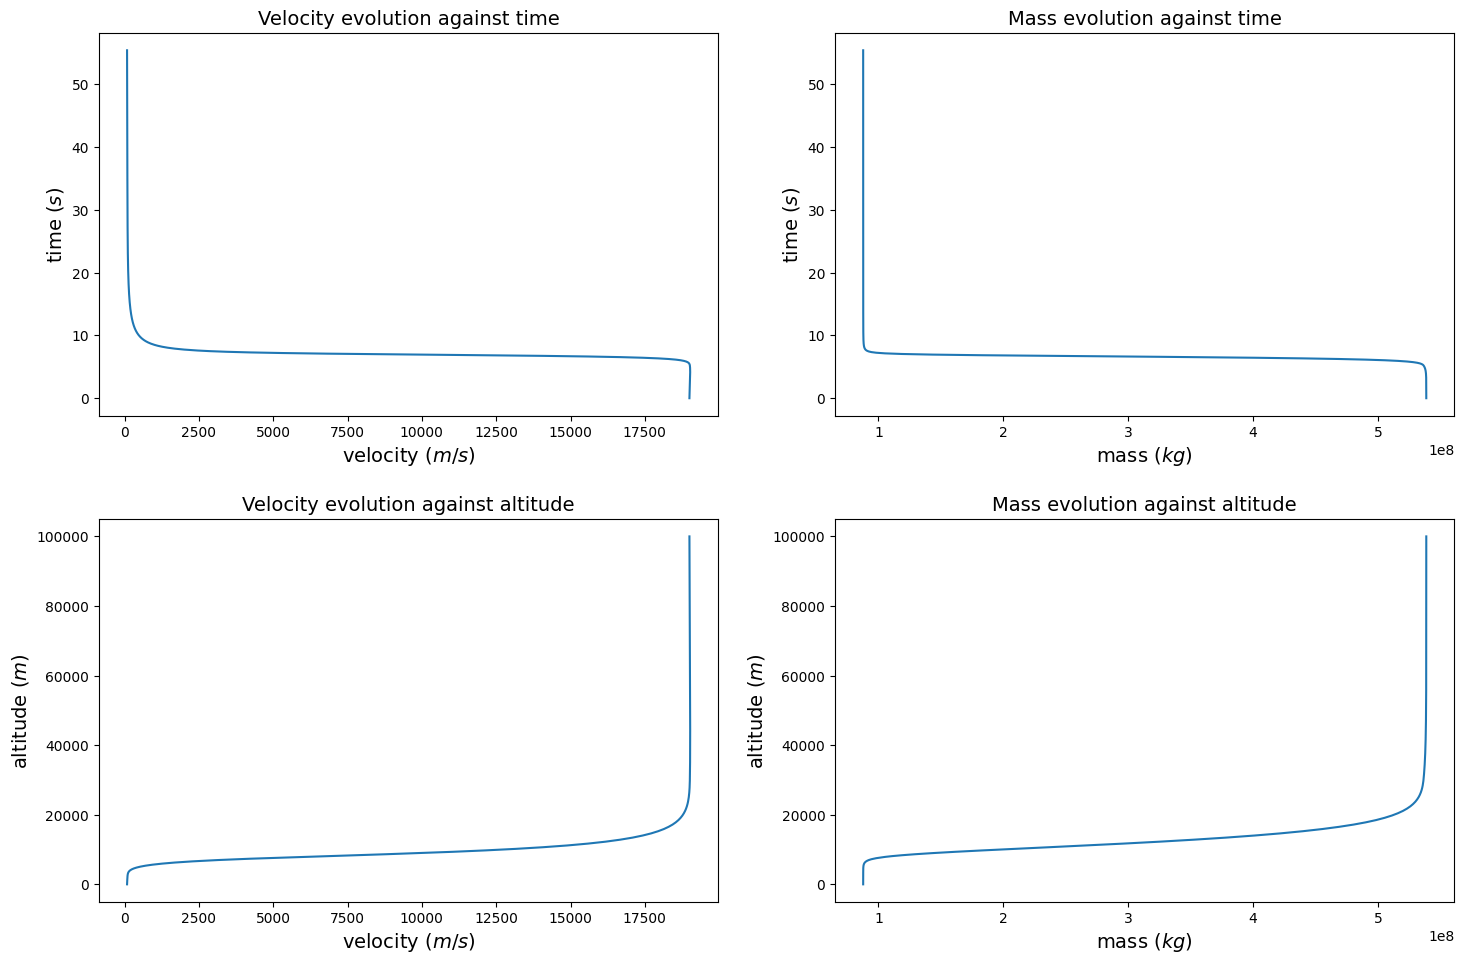

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(result1['velocity'], result1['time'])
ax1.set_ylabel('time $(s)$', fontsize=14)
ax1.set_xlabel('velocity $(m/s)$', fontsize=14)
ax1.set_title('Velocity evolution against time', fontsize=14)

ax2.plot(result1['mass'], result1['time'])
ax2.set_ylabel('time $(s)$', fontsize=14)
ax2.set_xlabel('mass $(kg)$', fontsize=14)
ax2.set_title('Mass evolution against time', fontsize=14)

ax3.plot(result1['velocity'], result1['altitude'])
ax3.set_ylabel('altitude $(m)$', fontsize=14)
ax3.set_xlabel('velocity $(m/s)$', fontsize=14)
ax3.set_title('Velocity evolution against altitude', fontsize=14)

ax4.plot(result1['mass'], result1['altitude'])
ax4.set_ylabel('altitude $(m)$', fontsize=14)
ax4.set_xlabel('mass $(kg)$', fontsize=14)
ax4.set_title('Mass evolution against altitude', fontsize=14)

plt.tight_layout(pad = 2.0)

### Function name: `calculate_energy`

Function to calculate the kinetic energy lost per unit altitude in kilotons TNT per km, for a given solution. This function takes the results from `solve_atmospheric_entry` to calculate the kinetic energy loss per unit altitude in kilotons TNT per km, which returns the same DataFrame as from `solve_atmospheric_entry`, but with an extra column 'dedz' added, where the kinetic energy loss is stored.

`Input:` 

**result** : DataFrame, A pandas dataframe with columns for the velocity, mass, angle, altitude, horizontal distance and radius as a function of time

`Output:`

**Returns** : DataFrame, returns the dataframe with additional column ``dedz`` which is the kinetic energy lost per unit altitude

### Example

In [5]:
result2 = earth.calculate_energy(result1)
result2

,velocity,mass,angle,altitude,distance,radius,time,dedz
0,19000.000000,5.387831e+08,45.000000,100000.000000,0.000000,35.000000,0.00,-0.000000
1,19000.346519,5.387831e+08,44.995097,99328.272076,661.441893,35.000000,0.05,-1.260177
2,19000.692985,5.387831e+08,44.990194,98656.587585,1323.015629,35.000000,0.10,-1.259919
3,19001.039389,5.387830e+08,44.985289,97984.950169,1984.732227,35.000000,0.15,-1.259613
4,19001.385736,5.387830e+08,44.980383,97313.356228,2646.580731,35.000000,0.20,-1.259308
...,...,...,...,...,...,...,...,...
1105,85.070285,8.775432e+07,89.193409,19.445489,97240.990478,257.488437,55.25,0.009917
1106,85.046678,8.775428e+07,89.197701,15.192961,97241.050195,257.488437,55.30,0.009912
1107,85.023083,8.775425e+07,89.201969,10.941655,97241.109564,257.488437,55.35,0.009906
1108,84.999499,8.775421e+07,89.206215,6.691477,97241.168614,257.488437,55.40,0.009901


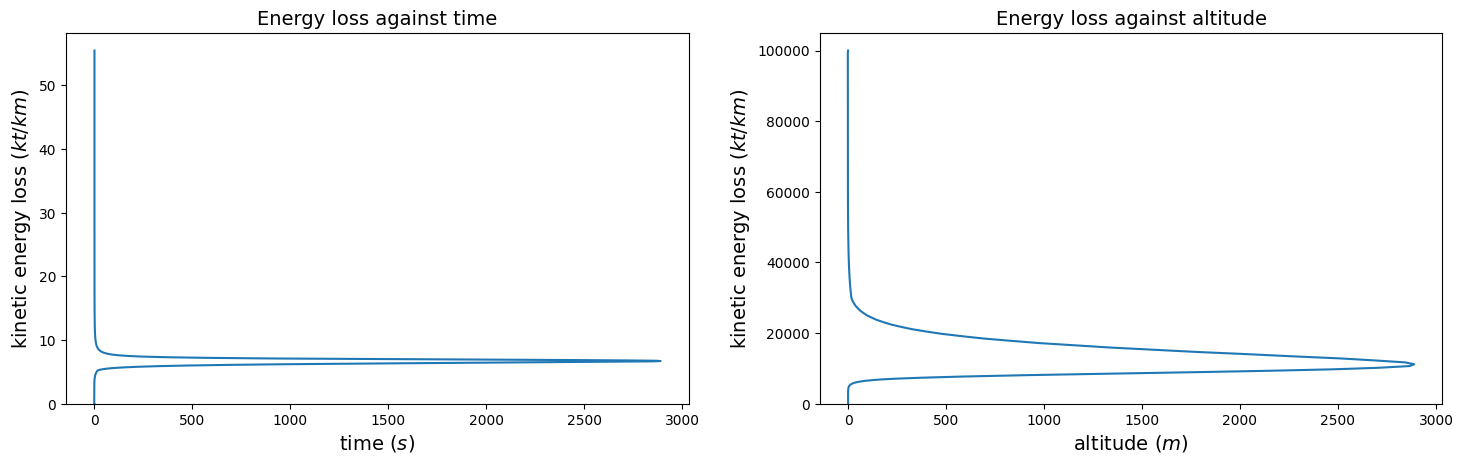

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(result2['dedz'][earth.burstpoint:], result2['time'][earth.burstpoint:])
ax1.set_ylim(ymin=0)
ax1.set_xlabel('time $(s)$', fontsize=14)
ax1.set_ylabel('kinetic energy loss $(kt/km)$', fontsize=14)
ax1.set_title('Energy loss against time', fontsize=14)

ax2.plot(result2['dedz'][earth.burstpoint:], result2['altitude'][earth.burstpoint:])
ax2.set_ylim(ymin=0)
ax2.set_xlabel('altitude $(m)$', fontsize=14)
ax2.set_ylabel('kinetic energy loss $(kt/km)$', fontsize=14)
ax2.set_title('Energy loss against altitude', fontsize=14)

plt.tight_layout(pad = 2.0)

### Function name: `analyse_outcome`

This function is where we compute the airburst point of the asteroid. This is equivalent to the point at which the peak energy loss per unit height reaches its maximum. An example outcome is displayed below, where each dictionary gives the detail of the impact event. The 'burst_energy' value gives a good estimation of the airburst energy for the total energy deposited into the atmosphere, which can then be used for hazard analysis.

`Input:` 

**result** : DataFrame, A pandas dataframe with columns for the velocity, mass, angle, altitude, horizontal distance and radius as a function of time

`Output:`

**Dict** : Dictionary with details of the impact event, which should contain the key: ``outcome`` (which should contain one of the following strings: ``Airburst`` or ``Cratering``), as well as the following 4 keys: ``burst_peak_dedz``, ``burst_altitude``, ``burst_distance``, ``burst_energy``

### Example

In [7]:
outcome = earth.analyse_outcome(result2)
outcome

{'outcome': 'Airburst',
 'burst_peak_dedz': 2888.8527063673228,
 'burst_altitude': 11170.25532312139,
 'burst_distance': 89084.14142115746,
 'burst_energy': 16195.827095213479}

Another point we want to mention is that our solver is able to use a tabulated atmospheric density profile.
In our *solver.planet().tabular_density* function, we use piecewise linear interpolation to fit the curve. Then the user can calculate the atmosphere density based on given altitude.

### Comparison with analytic solution

 We will also make a comparison between our software output and the analytical solution, which is derived with the simplifying assumptions of exponential atmosphere ($\rho_a = \rho_0 e^{-z/H}$), no gravitational acceleration ($g=0$), a flat planet ($R_p = \infty$), no lift ($C_L = 0$), no mass change owing to ablation ($\frac{dm}{dt}=0$) and no fragmentation ($\sigma_0 = \infty$, $\frac{dr}{dt}=0$). Under these assumptions, the system of ODEs only remains $\frac{dv}{dt}$ and $\frac{dz}{dt}$. We will derive the distance by applying: $$x_{i+1} = x_i + \frac{\Delta z}{tan \theta}$$  

To simple the analysis process we will apply forward euler method to derivate the result of analytical solution.

In [8]:
rho_0 = 1.2 #density of air
Q = 10**7 
H = 8000
C_d = 1
g = 9.81
#setting para for the asteroids ：
r0 = 50
v0 = 19.2e3
rho_m = 3300
theta0 = 18.3
m0 = (4/3)*np.pi*r0**3*rho_m
x0 = 0.
z0 = 100000.
A = np.pi*r0**2  
sin_theta = np.sin(theta0*np.pi/180)
cos_theta = np.cos(theta0*np.pi/180)
tan_theta = np.tan(theta0*np.pi/180)

def euler(tmax,dt) :
    global v,z,x,t
    t = np.linspace(0,tmax,int(tmax/dt)+1)
    v = np.zeros(len(t))
    z = np.zeros(len(t))
    x = np.zeros(len(t))
    v[0] = v0
    z[0] = z0
    for i in range(len(t)-1):
        rho_a = rho_0*np.exp(-z[i]/H)
        v[i+1] = v[i] + dt * (-((C_d*rho_a*A*v[i]**2)/(2*m0))+ g*sin_theta)
        z[i+1] = z[i] + dt * (-v[i]*sin_theta)
        x[i+1] = x[i] + dt* v[i] * cos_theta

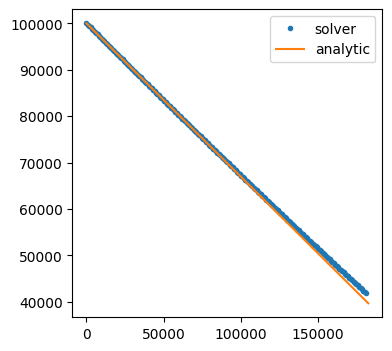

In [9]:
tmax = 10
dt = 0.05
euler(tmax, dt)
z = pd.Series(z)
x = pd.Series(x)
a = Planet()
b = a.solve_atmospheric_entry(radius=r0, velocity=v0, density=rho_m, strength =1e7, angle=theta0)
n = int(tmax/dt)+1
x1 = b['distance'].head(n)
z1 = b['altitude'].head(n)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.plot(x1,z1,'.',label='solver') # plot the point (2,3,4) on the figure
ax.plot(x,z,'-',label = 'analytic')
ax.legend()
plt.show()

From the figure we can observe that in the first few seconds, our solver perfectly matches the result of the analytical solutions.

# 2. Armageddon: locator

## `locator` module
* Calculate the great circle distance between pairs of points on a spherical Earth
* Return postcodes within specific distances of the location
* Return populations of a list of postcode units or sectors

### Function name: `great_circle_distance`

Calculate the great circle distance (in metres) between pairs of points specified as latitude and longitude on a spherical Earth (with radius 6371 km).

`Input:`

**latlon1** : arraylike latitudes and longitudes of first point (as [n, 2] array for n points)

**latlon2** : arraylike latitudes and longitudes of second point (as [m, 2] array for m points)

`Output:` 

**Distance**: Distance in metres between each pair of points (as an n x m array)

### Example

For example, to calculate the great circle distance between *[ 54.0, 0.0 ]* and *[ 55, 1.0 ]* and diatance between *[ 55.0, 0.0 ]* and *[ 55, 1 .0 ]* at the same time, we could use the code below

In [10]:
import numpy as np
fmt = lambda x: np.format_float_scientific(x, precision=3)
with np.printoptions(formatter={'all': fmt}):
   print(great_circle_distance([[54.0, 0.0], [55, 0.0]], [55, 1.0]))

[[1.286e+05]
 [6.378e+04]]


Calculate the great circle distance between *[[ 54.0, 0.0 ], [ 55.0, 1.0 ], [ 54.2, -3.0 ]]* and *[[ 55.0, 1.0 ], [ 56.0, -2.1 ], [ 54.001, -0.003 ]]* in pairs:

In [11]:
pnts1 = np.array([[54.0, 0.0], [55.0, 1.0], [54.2, -3.0]])
pnts2 = np.array([[55.0, 1.0], [56.0, -2.1], [54.001, -0.003]])
with np.printoptions(formatter={'all': fmt}):
   print(great_circle_distance(pnts1, pnts2))

[[1.286e+05 2.596e+05 2.254e+02]
 [9.494e-02 2.247e+05 1.286e+05]
 [2.725e+05 2.082e+05 1.966e+05]]


### `PostcodeLocator()` class

The class `PostcodeLocator()` contains functions to solve the system of ordinary differential equations and analyse the outcomes. It consists of two main functions:
* `get_postcodes_by_radius` for returning postcodes within specific distances of the location
* `get_population_of_postcode` for returning populations of a list of postcode units or sectors

The `__init__` function sets up postcode_file containing geographic location data for postcodes and census_file containing census data by postcode sector

### Function name: `get_postcodes_by_radius`

Return (unit or sector) postcodes within specific distances of input location.

`Input:`

**X** : arraylike Latitude-longitude pair of centre location

**radii** : arraylike array of radial distances from X

**sector** : bool, optional if true return postcode sectors, otherwise postcode units

`Output:` 

**place_list**: Contains the lists of postcodes closer than the elements of radii to the location X.

### Example

For example, the code below shows how to get postcodes within 0.13e3 meters of location coordinate (51.4981, -0.1773)

<div>
<img src="example.jpg" width="500"/>
</div>

In [12]:
locator = PostcodeLocator('../resources/full_postcodes.csv', '../resources/population_by_postcode_sector.csv')
locator.get_postcodes_by_radius((51.4981, -0.1773), [0.13e3])

[['SW7 2DD', 'SW7 5HQ', 'SW7 2BT', 'SW7 2BU', 'SW7 2AZ', 'SW7 5HF', 'SW7 5HG']]

The code below shows postcode sectors in different circles

|<div>
<img src="example2.jpg" width="500"/>
</div>

In [13]:
locator.get_postcodes_by_radius((51.4981, -0.1773), [0.4e3, 0.2e3], True)

[['SW7 9', 'SW7 5', 'SW7 2', 'SW7 4', 'SW7 3', 'SW7 1'],
 ['SW7 9', 'SW7 5', 'SW7 2', 'SW7 4', 'SW7 3', 'SW7 1']]

### Function name: `get_population_of_postcode`

Return populations of a list of postcode units or sectors.

`Input:` 

**postcodes** : list of postcode units or postcode sectors

**sector** : bool, if true return populations for postcode sectors, otherwise returns populations for postcode units

`Output:` 

**global_pc**: Contains the populations of input postcode units or sectors

### Example

To calculate population of different postcode units, just input them as a list

In [14]:
locator.get_population_of_postcode([['SW7 2AZ', 'SW7 2BT', 'SW7 2BU', 'SW7 2DD']])

[[19.0, 19.0, 19.0, 19.0]]

To calculate population of different postcode sectors, just input them as a list and add **True**

In [15]:
locator.get_population_of_postcode([['SW7  2']], True)

[[2283.0]]

# 3. Armageddon: damage

## `damage` module
* Calculate the location of the surface zero location and airblast damage radii (m)
* Calculate the risk for each affected UK postcode or postcode sector

### Function name: `damage_zones`

Calculate the latitude and longitude of the surface zero location and the
list of airblast damage radii (m) for a given impact scenario.

`Input:` 

**outcome**: Dict, the outcome dictionary from an impact scenario
        
**lat**: float, latitude of the meteoroid entry point (degrees)

**lon**: float, longitude of the meteoroid entry point (degrees)
    
**bearing**: float, bearing (azimuth) relative to north of meteoroid trajectory (degrees)
    
**pressures**: float, arraylike, list of threshold pressures to define airblast damage levels
    
`Output:`

**blat**: float, latitude of the surface zero point (degrees)
        
**blon**: float, longitude of the surface zero point (degrees)
        
**damrad**: arraylike, float, list of distances specifying the blast radii for the input damage levels

### Example

In [17]:
outcome = {'burst_altitude': 8e3, 'burst_energy': 7e3,
           'burst_distance': 90e3, 'burst_peak_dedz': 1e3,
           'outcome': 'Airburst'}
arr = damage_zones(outcome, 52.79, -2.95, 135, 
                   pressures=[1e3, 3.5e3, 27e3, 43e3],
                   )
arr

(52.21396905216966,
 -2.015908861677074,
 [115971.31673025587,
  42628.36651535611,
  9575.214234120964,
  5835.9834520793875])

We obtain the parameters below:

surface zero latitude|surface zero longitude|blast radii with the pressure level of 1e3|blast radii with the pressure level of 3.5e3|blast radii with the pressure level of 27e3|blast radii with the pressure level of 43e3|
|---------------|----------------|----------------|----------------|----------------|----------------|
|51.98371949678459|2.8338706741653983|115971.31673025587|42628.36651535611|9575.214234120964|5835.9834520793875|        
 

In [18]:
damage_map(arr[0],arr[1], arr[2], 52.79, -2.95)


**Explaination:**
    
The damage zones are marked on the plot above. As the plot and calculations shows, when the radius(horizontal range) goes up, the pressure in this wave decreases. When the asteroids blast occurs, the nearer area will experience relatively greater pressure, while the further area will experience relatively lower pressure.This is also proved by the equation:
    
\begin{equation*}
p(r) = 3.14 \times 10^{11} \left(\frac{r^2 + z_b^2}{E_k^{2/3}}\right)^{-1.3} + 1.8 \times 10^{7} \left(\frac{r^2 + z_b^2}{E_k^{2/3}}\right)^{-0.565}
\end{equation*}

$p$ (in Pa) (above ambient, also known as overpressure): the pressure in this wave

$E_k$ (in kilotons of TNT equivalent): explosion energy

$z_b$ (in m): burst altitude

$r$ (in m): horizontal range


### Function name: `impact_risk`

Perform an uncertainty analysis to calculate the risk for each affected UK postcode or postcode sector

`Input:` 

**planet**: armageddon.Planet instance, the Planet instance from which to solve the atmospheric entry

**means**: dict, a dictionary of mean input values for the uncertainty analysis. This should include values for ``radius``, ``angle``, ``strength``, ``density``, ``velocity``, ``lat``, ``lon`` and ``bearing``

**stdevs**: dict, a dictionary of standard deviations for each input value. This should include values for ``radius``, ``angle``, ``strength``, ``density``, ``velocity``, ``lat``, ``lon`` and ``bearing``

**pressure**: float, a single pressure at which to calculate the damage zone for each impact

**nsamples**: int, the number of iterations to perform in the uncertainty analysis

**sector**: logical, optional, if True (default) calculate the risk for postcode sectors, otherwise calculate the risk for postcodes

`Output:`

**risk**: DataFrame, a pandas DataFrame with columns for postcode (or postcode sector) and the associated risk. These should be called ``postcode`` or ``sector``, and ``risk``.

### Example

In [19]:
p = Planet()
fiducial_means = {'radius': 35, 'angle': 45, 'strength': 1e7,
                  'density': 3000, 'velocity': 19e3,
                  'lat': 53.0, 'lon': -2.5, 'bearing': 115.}
fiducial_stdevs = {'radius': 1, 'angle': 1, 'strength': 5e6,
                   'density': 500, 'velocity': 1e3,
                   'lat': 0.025, 'lon': 0.025, 'bearing': 0.5}
df = impact_risk(p, means=fiducial_means, stdevs=fiducial_stdevs, pressure=27.e3, nsamples=10, sector=True)
df.head(10)

/Users/aa3019/Documents/assessments/group_project1/acs-armageddon-Dimorphos/armageddon/damage.py:79: RuntimeWarning: invalid value encountered in sqrt
  initial = np.sqrt(pre_sol)
/opt/homebrew/Caskroom/miniconda/base/envs/group_project/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/aa3019/Documents/assessments/group_project1/acs-armageddon-Dimorphos/armageddon/damage.py:79: RuntimeWarning: invalid value encountered in sqrt
  initial = np.sqrt(pre_sol)
/opt/homebrew/Caskroom/miniconda/base/envs/group_project/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


,postcode sector,risk
0,LE3 6,10364.0
1,LE199,0.0
2,LE9 7,9664.8
3,LE4 0,12207.2
4,LE194,3284.0
5,LE4 8,7734.4
6,LE3 8,8135.2
7,LE1 9,0.0
8,LE3 9,13120.8
9,LE2 8,8666.4


The above example calculates the risk parameter of each sector in England caused by the asteroid's blast, which predicts the population of each area that could be affected. It takes parameters of the planet's condition and returns the postcodes of the area that could be affected. A number of tests are carried out to calculate the probability of the area being affected. The production of the probability and the population of the area is the risk number of the area.

# 4. Armageddon: extensions

## `extensions` module
* Find the optimal radius and strength of the dataset with respect to the given density, angle, velocity and radians

### Function name: `findstrengthradius`

Find the optimal radius and strength of the input dataset that minimize the error with respect to the given density, angle, velocity and radians

`Input:` 

**velocity**: float, the entery speed of the asteroid in meters/second

**density**: float, the density of the asteroid in kg/m^3

**angle**: float, the initial trajectory angle of the asteroid to the horizontal. By default, input is in degrees. If 'radians' is set to True, the input should be in radians

**init_altitude**: float, optional, initial altitude in m

**dt**: float, optional, the output timestep, in s

**data_file**: str, optional, file contains the data of interest

**radians**: logical, optional, Whether angles should be given in degrees or radians. Default=False. Angles returned in the dataframe will have the same units as the input

**backend**: str, optional, Which solving method to use. Default='FE'

`Output:`

**best_radius**: float, best radius that minimize the error

**minerror**: float, minimum error found

**beststrength**: float, best strength that minimize the error

### Example

In [20]:
r, f, s =findstrengthradius(
                density=3300, angle=18.3, velocity=19200,
                data_file='../resources/ChelyabinskEnergyAltitude.csv',
                radians=False)

100 1
f: 1329153.63143691 5492976.124609468
x: 38.8146351137604 62.1853648862396

62.1853648862396 1
f: 310393.6171031613 1329153.63143691
x: 24.37072977247918 38.8146351137604

38.8146351137604 1
f: 58003.87152988026 310393.6171031613
x: 15.443905341281225 24.37072977247918

24.37072977247918 1
f: 4878.560159816467 58003.87152988026
x: 9.926824431197948 15.443905341281225

15.443905341281225 1
f: 5939.854558211099 4878.560159816467
x: 6.517080910083277 9.926824431197948

15.443905341281225 6.517080910083277
f: 4878.560159816467 13710.499805886548
x: 9.926824431197948 12.034161820166556

12.034161820166556 6.517080910083277
f: 1282.732124810372 4878.560159816467
x: 8.624418299051888 9.926824431197948

9.926824431197948 6.517080910083277
f: 1225.9023845148106 1282.732124810372
x: 7.819487042229337 8.624418299051888

8.624418299051888 6.517080910083277
f: 2897.429203009883 1225.9023845148106
x: 7.322012166905829 7.819487042229337

8.624418299051888 7.322012166905829
f: 1225.9023845148106

In [21]:
r, f, s

(8.207613586981935, 86.41223448013196, 4570808.233827251)

We obtain the optimal r, f, s, which are 8.207613586981935, 86.41223448013302, 4570808.233827251

# 5. GUI Guide

* Utilize GUI to help you visualize how a specific asteroids would influence the earth.

**Step 1**: Use command line to open GUI 

```
python gui/interface.pyto
```

We will see the window below:

<div>
<img src="example3.jpg" width="500"/>
</div>

**step2**: Input your parameters and click "**Calculate**", it will jump to the html website

<div>
<img src="example4.jpg" width="500"/>
</div>

The circle is the area which will be affected by the airburst